In [1]:
%matplotlib inline
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
import glob
import nibabel as nib
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
import segmentation_models_3D as sm
import keras
from keras.models import load_model
from keras.metrics import MeanIoU

Segmentation Models: using `tf.keras` framework.


### display sample

In [3]:
_flair = 'BraTS2021_Training_Data/BraTS2021_00000/BraTS2021_00000_flair.nii.gz'
_t1 = 'BraTS2021_Training_Data/BraTS2021_00000/BraTS2021_00000_t1.nii.gz'
_t1c = 'BraTS2021_Training_Data/BraTS2021_00000/BraTS2021_00000_t1ce.nii.gz'
_t2 = 'BraTS2021_Training_Data/BraTS2021_00000/BraTS2021_00000_t2.nii.gz'
_label = 'BraTS2021_Training_Data/BraTS2021_00000/BraTS2021_00000_seg.nii.gz'
sample =  {"t1":_t1, "t2":_t2, "t1c":_t1c,"flair":_flair, "label":_label}
depth = random.randint(50,100)

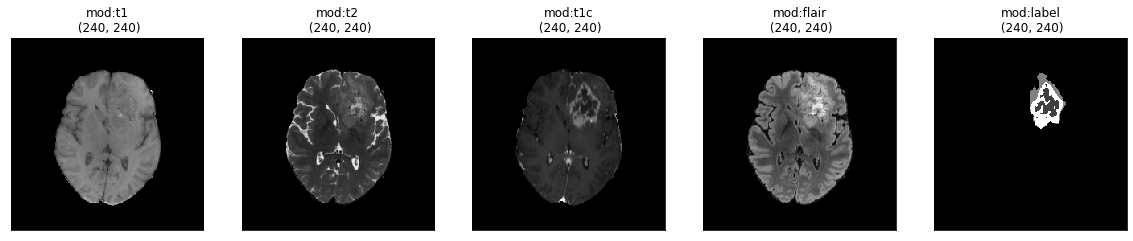

In [4]:
i = 1
fig = plt.figure(figsize=(20, 20))
for j in sample:
    img = sitk.GetArrayFromImage(sitk.ReadImage(sample[j]))
    fig.add_subplot(1,5,i)
    plt.imshow(img[depth,:,:],interpolation='nearest', cmap='gray')
    plt.title("mod:{}\n {}".format(j,img.shape[1:]))
    plt.xticks([])
    plt.yticks([])
    i = i + 1

In [5]:
t1_list = sorted(glob.glob('BraTS2021_Training_Data/*/*t1.nii.gz'))
t2_list = sorted(glob.glob('BraTS2021_Training_Data/*/*t2.nii.gz'))
t2_list = sorted(glob.glob('BraTS2021_Training_Data/*/*t2.nii.gz'))
t1ce_list = sorted(glob.glob('BraTS2021_Training_Data/*/*t1ce.nii.gz'))
flair_list = sorted(glob.glob('BraTS2021_Training_Data/*/*flair.nii.gz'))
mask_list = sorted(glob.glob('BraTS2021_Training_Data/*/*seg.nii.gz'))

In [6]:
scaler = MinMaxScaler()
slice_b = 13
slice_t = 141
num_data = len(t1_list)

### Save as a slice

In [8]:
for img in range(num_data):

    image_t2=nib.load(t2_list[img]).get_fdata()
    image_t2=scaler.fit_transform(image_t2.reshape(-1, image_t2.shape[-1])).reshape(image_t2.shape)
 
 
    image_t1ce= nib.load(t1ce_list[img]).get_fdata()
    image_t1ce= scaler.fit_transform(image_t1ce.reshape(-1, image_t1ce.shape[-1])).reshape(image_t1ce.shape)

    image_flair= nib.load(flair_list[img]).get_fdata()
    image_flair= scaler.fit_transform(image_flair.reshape(-1, image_flair.shape[-1])).reshape(image_flair.shape)
 
    mask= nib.load(mask_list[img]).get_fdata()
    mask= mask.astype(np.uint8)
    
    val, counts = np.unique(mask, return_counts=True)

   
    mask[mask==4] = 3

    
    if (1 - (counts[0]/counts.sum())) > 0.01:
    
        for s in range(slice_b,slice_t):


            temp_combined_images = np.stack([image_flair[:,:,s], image_t1ce[:,:,s], image_t2[:,:,s]], axis=2)
            temp_combined_images=temp_combined_images[56:184, 56:184]


            temp_mask = mask[:,:,s]
            temp_mask=temp_mask[56:184, 56:184] 
            temp_mask= to_categorical(temp_mask, num_classes=4)


            np.save('Sliced-Dataset-2D/images/image_'+str(img)+'_'+str(s)+'.npy', temp_combined_images)
            np.save('Sliced-Dataset-2D/masks/mask_'+str(img)+'_'+str(s)+'.npy', temp_mask)


        
    

### Divide the dataset into training and validation

In [9]:
import splitfolders

input_folder = 'Sliced-Dataset-2D/'
output_folder = 'Sliced-Dataset-128/'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

Copying files: 119296 files [26:44, 74.33 files/s] 


### ِِData generator

In [2]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'npy'):

            image = np.load(img_dir+image_name)

            images.append(image)
    images = np.array(images)

    return(images)

In [3]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size

### Test the data generator

In [4]:
train_img_dir = "Sliced-Dataset-128/train/images/"
train_mask_dir = "Sliced-Dataset-128/train/masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 64

train_img_datagen = imageLoader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)

In [13]:
img, msk = train_img_datagen.__next__()

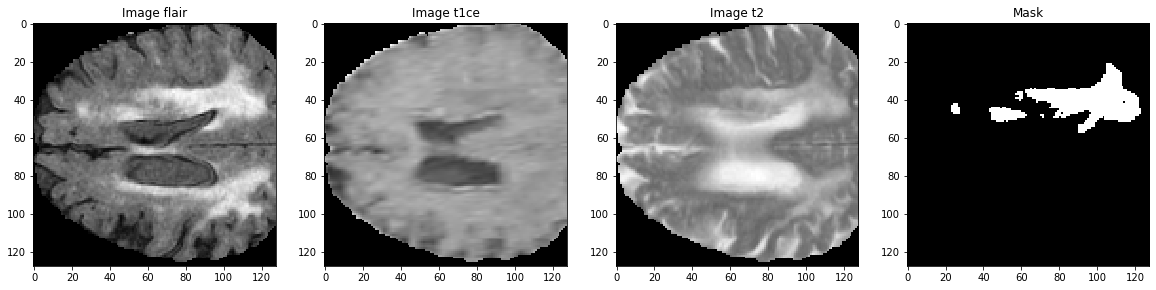

In [14]:
test_img=img[2]
test_mask=msk[2]
test_mask=np.argmax(test_mask, axis=2)



fig = plt.figure(figsize=(20, 20))
fig.add_subplot(1,4,1)
plt.imshow(test_img[:,:, 0],interpolation='nearest', cmap='gray')
plt.title('Image flair')
fig.add_subplot(1,4,2)
plt.imshow(test_img[:,:, 1],interpolation='nearest', cmap='gray')
plt.title('Image t1ce')
fig.add_subplot(1,4,3)
plt.imshow(test_img[:,:,2],interpolation='nearest', cmap='gray')
plt.title('Image t2')
fig.add_subplot(1,4,4)
plt.imshow(test_mask, interpolation='nearest', cmap='gray')
plt.title('Mask')
plt.show()


### Build model

In [4]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform'

In [5]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible.
    model.summary()

    return model

#Test if everything is working ok.
model = simple_unet_model(128, 128,3, 4)
print(model.input_shape)
print(model.output_shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

 conv2d_transpose_3 (Conv2DTran  (None, 128, 128, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 128, 128, 32  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'conv2d_1[0][0]']               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 16  4624        ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 dropout_8 (Dropout)            (None, 128, 128, 16  0           ['conv2d_16[0][0]']              
          

In [5]:
train_img_dir = "Sliced-Dataset-128/train/images/"
train_mask_dir = "Sliced-Dataset-128/train/masks/"

val_img_dir = "Sliced-Dataset-128/val/images/"
val_mask_dir = "Sliced-Dataset-128/val/masks/"


train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [7]:
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]
batch_size = 64
LR = 0.0001
optim = keras.optimizers.Adam(LR)

In [8]:
model = simple_unet_model(IMG_HEIGHT=128,
                          IMG_WIDTH=128,
                          IMG_CHANNELS=3,
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 128, 128, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

 conv2d_transpose_7 (Conv2DTran  (None, 128, 128, 16  2064       ['conv2d_34[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatenate_7 (Concatenate)    (None, 128, 128, 32  0           ['conv2d_transpose_7[0][0]',     
                                )                                 'conv2d_20[0][0]']              
                                                                                                  
 conv2d_35 (Conv2D)             (None, 128, 128, 16  4624        ['concatenate_7[0][0]']          
                                )                                                                 
                                                                                                  
 dropout_17 (Dropout)           (None, 128, 128, 16  0           ['conv2d_35[0][0]']              
          

In [9]:
train_img_datagen = imageLoader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)
val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

In [10]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=20,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

model.save('brats_2d_v4_big.hdf5')

Epoch 1/20
699/699 [==============================] - 2915s 4s/step - loss: 0.7949 - accuracy: 0.9170 - iou_score: 0.8561 - val_loss: 0.7836 - val_accuracy: 0.9463 - val_iou_score: 0.8885
Epoch 2/20
699/699 [==============================] - 2650s 4s/step - loss: 0.7712 - accuracy: 0.9573 - iou_score: 0.9203 - val_loss: 0.7760 - val_accuracy: 0.9482 - val_iou_score: 0.9022
Epoch 3/20
699/699 [==============================] - 2625s 4s/step - loss: 0.7682 - accuracy: 0.9621 - iou_score: 0.9287 - val_loss: 0.7709 - val_accuracy: 0.9567 - val_iou_score: 0.9187
Epoch 4/20
699/699 [==============================] - 2620s 4s/step - loss: 0.7663 - accuracy: 0.9654 - iou_score: 0.9348 - val_loss: 0.7702 - val_accuracy: 0.9582 - val_iou_score: 0.9210
Epoch 5/20
699/699 [==============================] - 2614s 4s/step - loss: 0.7649 - accuracy: 0.9682 - iou_score: 0.9397 - val_loss: 0.7682 - val_accuracy: 0.9619 - val_iou_score: 0.9275
Epoch 6/20
699/699 [==============================] - 2617s 

In [6]:
my_model = load_model('brats_2d_v4_big.hdf5', compile=False)

In [7]:
batch_size=64 
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)


test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


2/2 [==============================] - 1s 292ms/step
Mean IoU = 0.6824362


In [19]:
def plot_result(img_num, slice_num):
    test_img = np.load("Sliced-Dataset-128/val/images/image_"+str(img_num)+'_'+str(slice_num)+".npy")

    test_mask = np.load("Sliced-Dataset-128/val/masks/mask_"+str(img_num)+'_'+str(slice_num)+".npy")
    test_mask_argmax=np.argmax(test_mask, axis=2)

    test_img_input = np.expand_dims(test_img, axis=0)
    test_prediction = my_model.predict(test_img_input)
    test_prediction_argmax=np.argmax(test_prediction, axis=3)[0,:,:]
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[:,:,1], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(test_mask_argmax[:,:])
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(test_prediction_argmax[:,:])
    plt.show()


1/1 [==============================] - 0s 47ms/step


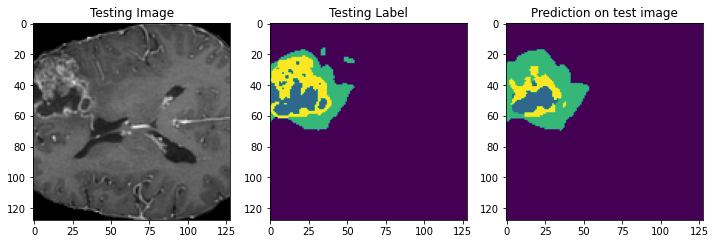

In [20]:
plot_result(505, 77)

1/1 [==============================] - 0s 54ms/step


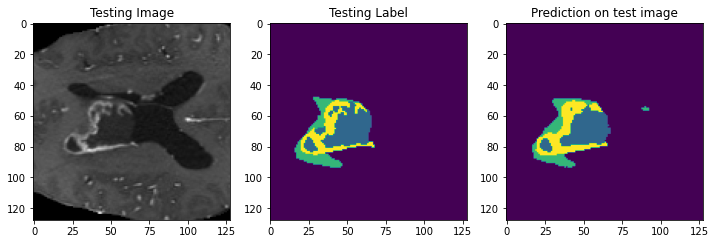

In [21]:
plot_result(117, 78)

1/1 [==============================] - 0s 48ms/step


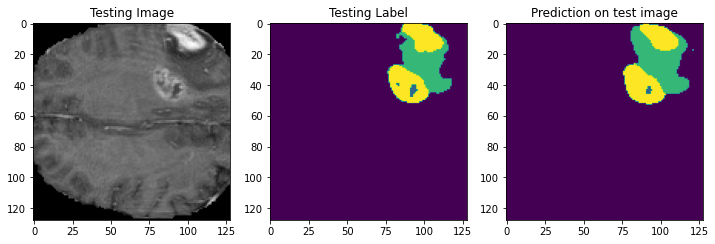

In [24]:
plot_result(605, 104)

1/1 [==============================] - 0s 56ms/step


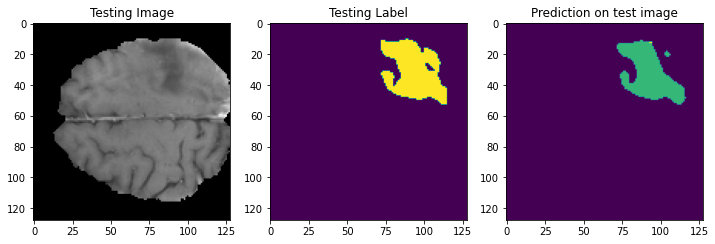

In [27]:
plot_result(607, 117)

1/1 [==============================] - 0s 60ms/step


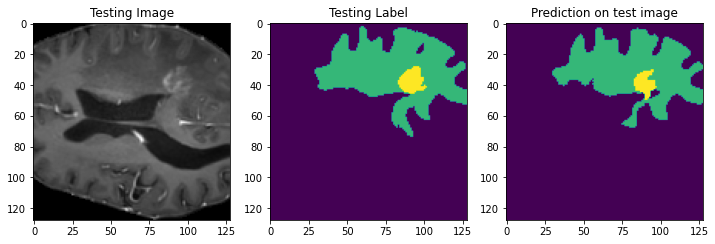

In [28]:
plot_result(520, 87)

1/1 [==============================] - 0s 49ms/step


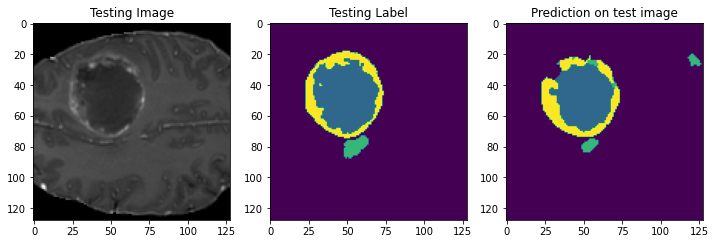

In [29]:
plot_result(453, 98)

1/1 [==============================] - 0s 61ms/step


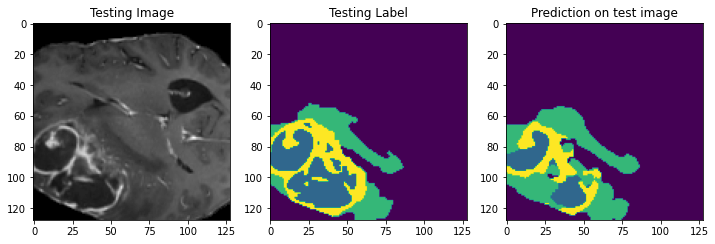

In [30]:
plot_result(500, 81)

1/1 [==============================] - 0s 49ms/step


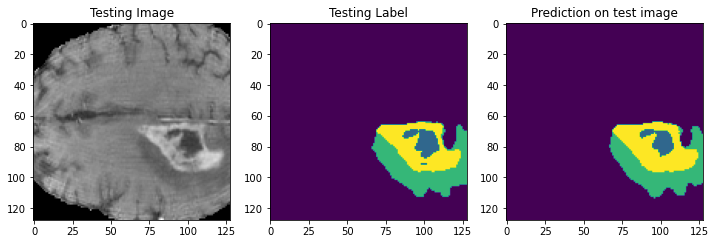

In [32]:
plot_result(603, 98)

1/1 [==============================] - 0s 29ms/step


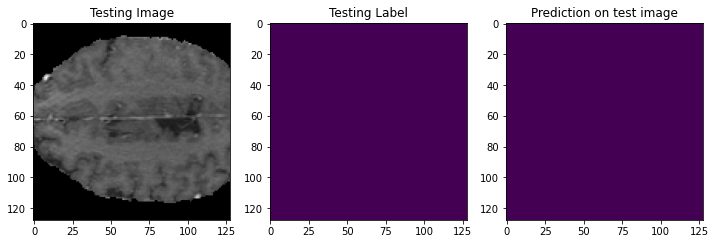

In [33]:
plot_result(805,105)

1/1 [==============================] - 0s 29ms/step


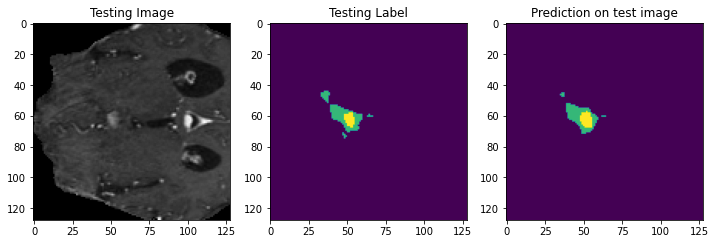

In [36]:
plot_result(889, 70)

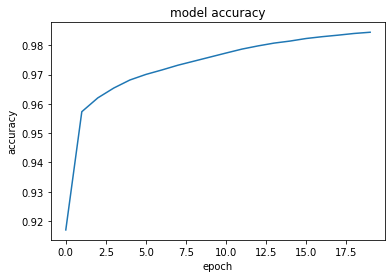

In [27]:
#Accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

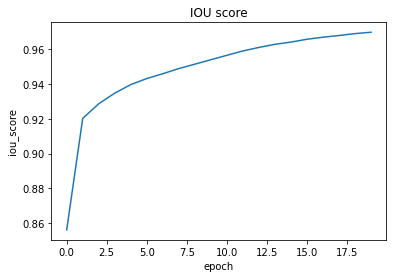

In [28]:
plt.plot(history.history['iou_score'])
plt.title('IOU score')
plt.ylabel('iou_score')
plt.xlabel('epoch')
plt.show()

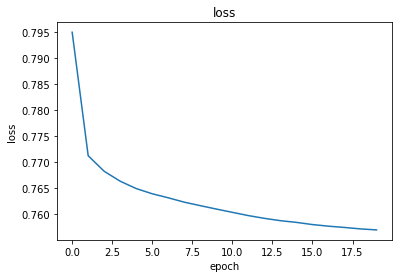

In [29]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()